# Activation Patching by attention layers, mlps, and every token

In [1]:
from nnsight import LanguageModel
import einops
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
llm = LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto", torch_dtype=torch.bfloat16)

In [3]:
llm.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
)

In [4]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [5]:
prompt = """The capital of France is Paris.
The capital of France is Berlin.
Now I will give the correct answer.
The capital of France is"""

corrupted_prompt = """The capital of France is Paris.
The capital of France is Berlin.
Now I will give the incorrect answer.
The capital of France is"""

prompts = [prompt, corrupted_prompt]

In [6]:
# Define the answers to these prompts, formatted as (correct, incorrect)
answers = [
    (" Paris", " Berlin"),
    (" Berlin", " Paris")
]

In [7]:
# Tokenize clean and corrupted prompts
clean_tokens = llm.tokenizer(prompts[0], return_tensors="pt")["input_ids"]
corrupted_tokens = llm.tokenizer(prompts[1], return_tensors="pt")["input_ids"]

answer_token_indices = [
    [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
    for i in range(len(answers))
]
print("answer_token_indices=", answer_token_indices)

answer_token_indices= [[12366, 20437], [20437, 12366]]


In [8]:
patching_results = {layer: {"attn": {}, "mlp": {}} for layer in range(N_LAYERS)}  # Pre-allocate layer keys
z_l = {}

with llm.trace() as tracer:
    # Clean run, grab clean activations for layer
    with tracer.invoke(prompts[0]) as invoker:
        clean_tokens = invoker.inputs[0][0]["input_ids"][0]
        for layer in range(N_LAYERS):
            z_l[layer] = {
                "attn": llm.model.layers[layer].self_attn.output.save(),
                "mlp": llm.model.layers[layer].mlp.output.save()
            }
        print("clean_tokens=", clean_tokens)
        
        # Get logits from lm_head
        clean_logits = llm.lm_head.output
        clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

    # Corrupter run, grab the corrupted logits for later comparison    
    with tracer.invoke(prompts[1]) as invoker:
        corrupted_tokens = invoker.inputs[0][0]["input_ids"][0]
        corrupted_logits = llm.lm_head.output
        corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()

    

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


clean_tokens= tensor([128000,    791,   6864,    315,   9822,    374,  12366,    627,    791,
          6864,    315,   9822,    374,  20437,    627,   7184,    358,    690,
          3041,    279,   4495,   4320,    627,    791,   6864,    315,   9822,
           374])


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [10]:
# Patching
# Start with the activation patching: iterate through all the layers
for layer in range(N_LAYERS):
    for token_idx in range(len(clean_tokens)):  
        with llm.trace(prompts[1]):
            # Activation patching MLP
            llm.model.layers[layer].mlp.output[:, token_idx, :] = z_l[layer]["mlp"][:, token_idx, :]
            patched_logits = llm.lm_head.output
            patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
            patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
            patching_results[layer]["mlp"][f"token_{token_idx}"] = patched_result.item().save() 

        with llm.trace(prompts[1]):
            # Activation patching attention
            llm.model.layers[layer].self_attn.output[0][:, token_idx, :] = z_l[layer]["attn"][0][:, token_idx, :]
            patched_logits = llm.lm_head.output
            patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
            patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
            patching_results[layer]["attn"][f"token_{token_idx}"] = patched_result.item().save() 

In [11]:
patching_results_total = {
    "clean_run_logit_difference": clean_logit_difference,
    "corrupted_run_logit_difference": corrupted_logit_difference,
    "patching_results": patching_results
}

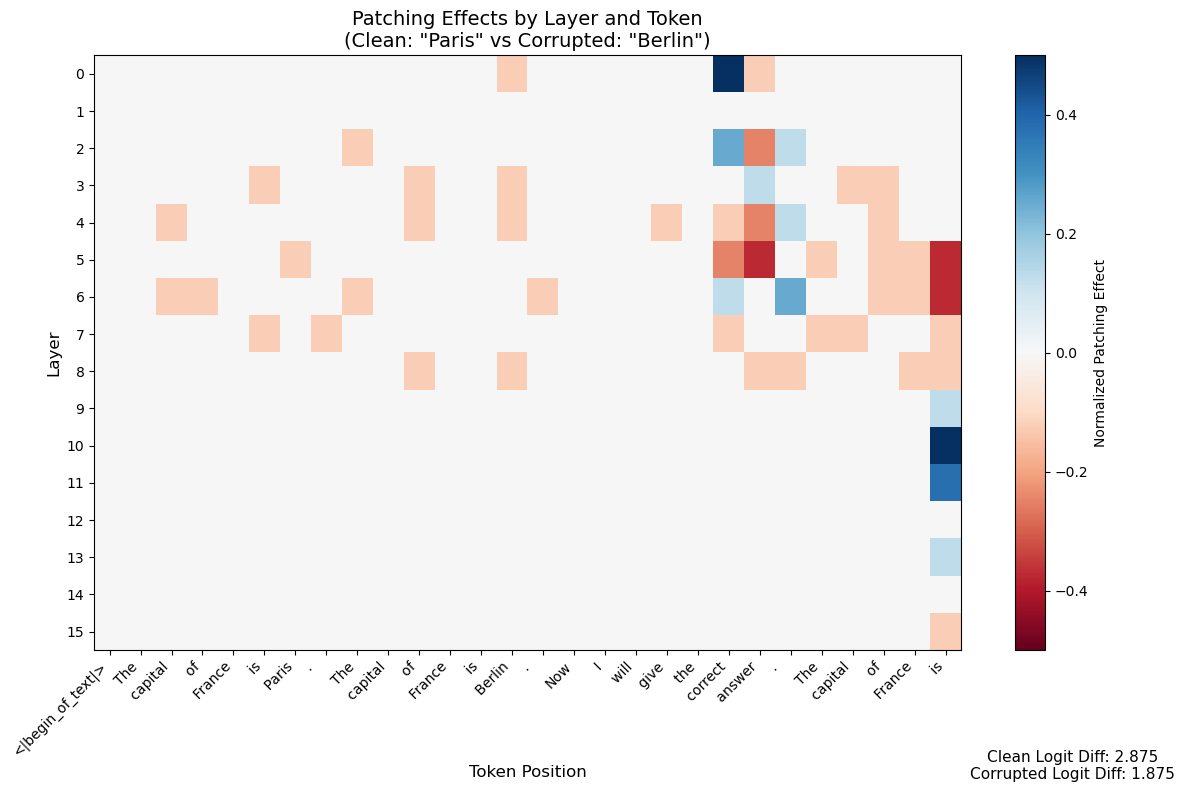

In [ ]:
# Plotting: Heatmap of layer vs. token effects
N_LAYERS = len(patching_results)
seq_len = len(clean_tokens)
layer_token_effects = np.zeros((N_LAYERS, seq_len))

for layer in range(N_LAYERS):
    for token_idx in range(seq_len):
        layer_token_effects[layer, token_idx] = float(patching_results[layer][f"token_{token_idx}"].value)

clean_diff = float(patching_results_total["clean_run_logit_difference"].item())
corrupted_diff = float(patching_results_total["corrupted_run_logit_difference"].item())

plt.figure(figsize=(12, 8))
im = plt.imshow(layer_token_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='Normalized Patching Effect')

# Customize axes with token text (optional)
token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
plt.xlabel('Token Position', fontsize=12)
plt.ylabel('Layer', fontsize=12)
plt.title('Patching Effects by Layer and Token\n(Clean: "Paris" vs Corrupted: "Berlin")', fontsize=14)
plt.xticks(np.arange(seq_len), labels=token_labels, fontsize=10, rotation=45, ha='right')
plt.yticks(np.arange(N_LAYERS), labels=[f'{i}' for i in range(N_LAYERS)], fontsize=10)

# Add clean/corrupted context
plt.figtext(0.9, 0.02, f'Clean Logit Diff: {clean_diff:.3f}\nCorrupted Logit Diff: {corrupted_diff:.3f}',
            fontsize=11, ha='center')

plt.tight_layout()
plt.savefig('patching_effects_heatmap.pdf', format='pdf', dpi=300)
plt.show()

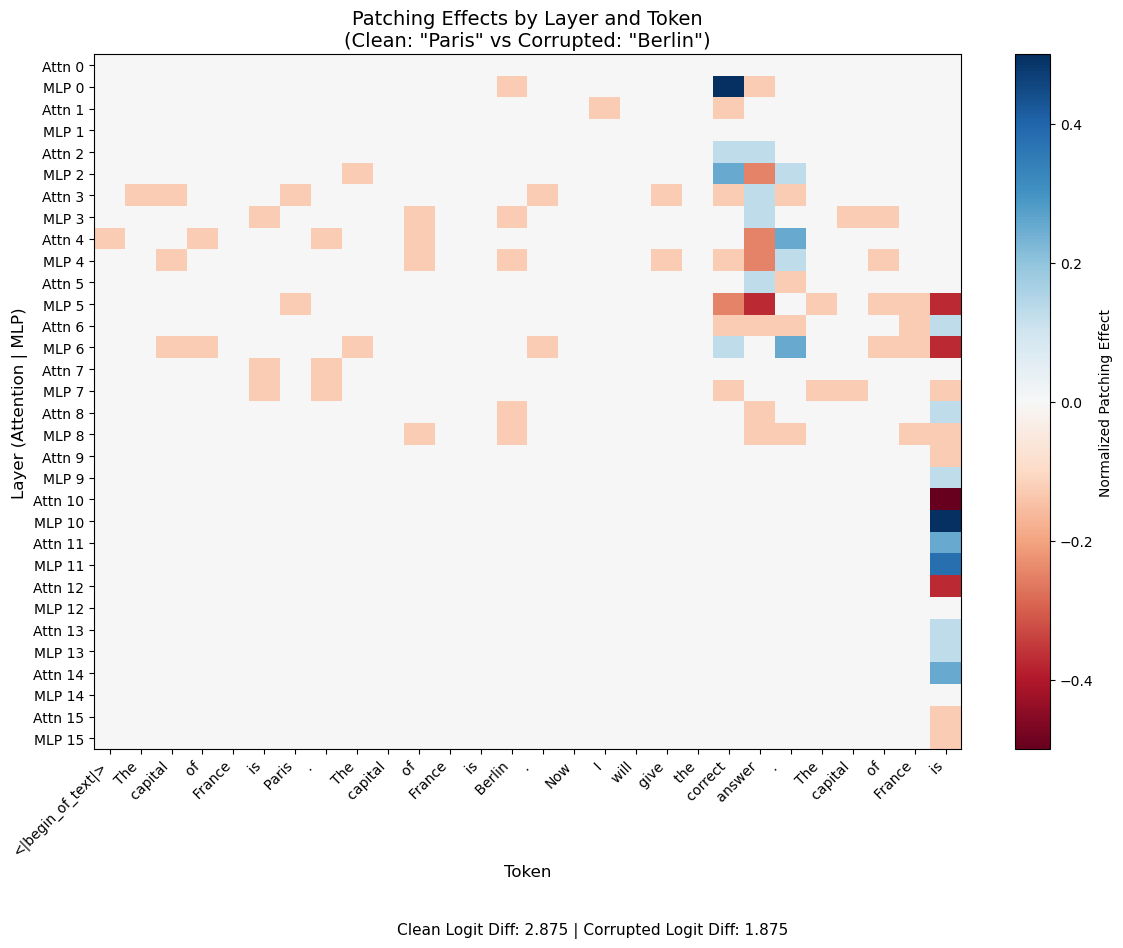

In [15]:
# Plotting: Single heatmap with Attention and MLP interleaved on Y-axis
N_LAYERS = len(patching_results)
seq_len = len(clean_tokens)

# Extract data for attention and MLP, interleaving them on the Y-axis
combined_effects = np.zeros((N_LAYERS * 2, seq_len))  # Each layer has two rows: Attention and MLP

for layer in range(N_LAYERS):
    for token_idx in range(seq_len):
        attn_effect = float(patching_results[layer]["attn"][f"token_{token_idx}"].value)
        mlp_effect = float(patching_results[layer]["mlp"][f"token_{token_idx}"].value)
        combined_effects[layer * 2, token_idx] = attn_effect      # Attention row
        combined_effects[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

clean_diff = float(patching_results_total["clean_run_logit_difference"].item())
corrupted_diff = float(patching_results_total["corrupted_run_logit_difference"].item())

# Create the heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(combined_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='Normalized Patching Effect')

# Customize axes
token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
plt.xlabel('Token', fontsize=12)
plt.ylabel('Layer (Attention | MLP)', fontsize=12)
plt.title('Patching Effects by Layer and Token\n(Clean: "Paris" vs Corrupted: "Berlin")', fontsize=14)

# X-axis: Token labels
plt.xticks(np.arange(seq_len), labels=token_labels, fontsize=10, rotation=45, ha='right')

# Y-axis: Interleave Attention and MLP labels for each layer
y_labels = []
for layer in range(N_LAYERS):
    y_labels.extend([f'Attn {layer}', f'MLP {layer}'])
plt.yticks(np.arange(N_LAYERS * 2), labels=y_labels, fontsize=10)

# Add clean/corrupted context
plt.figtext(0.5, 0.01, f'Clean Logit Diff: {clean_diff:.3f} | Corrupted Logit Diff: {corrupted_diff:.3f}', 
            fontsize=11, ha='center')

# Adjust layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('patching_effects_heatmap_single_swapped.pdf', format='pdf', dpi=300)
plt.show()